In [7]:
!nvidia-smi

Wed May 16 17:43:42 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:05:00.0 Off |                  N/A |
| 22%   48C    P8    16W / 250W |  11721MiB / 12205MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

(791, 250, 250, 3)
(791,)
(784, 250, 250, 3)
(784,)


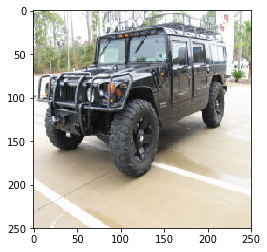

In [10]:
# -*- coding: utf-8 -*-
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator


batch_size = 32
num_classes = 20
epochs = 50

#### LOAD AND TRANSFORM

# ## Download: ONLY ONCE!
# !wget https://www.dropbox.com/s/kdhn10jwj99xkv7/data.tgz
# !tar xvzf data.tgz
# #####


# Load 
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

## View some images
plt.imshow(x_train[2,:,:,: ] )
plt.show()


## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255


## Labels
y_train=y_train-1

y_test=y_test-1

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [20]:
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint

# load the model
model1 = VGG16(weights='imagenet', include_top=False, input_shape=x_train.shape[1:])

#############################
###      BILINEAR        ####
#############################

for layer in model1.layers:
    layer.trainable = False

def outer_product(x):
  phi_I = tf.einsum('ijkm,ijkn->imn',x[0],x[1])		# Einstein Notation  [batch,1,1,depth] x [batch,1,1,depth] -> [batch,depth,depth]
  phi_I = tf.reshape(phi_I,[-1,512*512])	        # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
  phi_I = tf.divide(phi_I,31*31)								  # Divide by feature map size [sizexsize]

  y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))		# Take signed square root of phi_I
  z_l2 = tf.nn.l2_normalize(y_ssqrt, dim=1)								              # Apply l2 normalization
  return z_l2



conv=model1.get_layer('block5_conv3') # block5_conv3
d1=Dropout(0.5)(conv.output)
d2=Dropout(0.5)(conv.output)

x = Lambda(outer_product, name='outer_product')([d1,d2])

predictions=Dense(num_classes, activation='softmax', name='predictions')(x)

model = Model(inputs=model1.input, outputs=predictions)


# DEFINE A LEARNING RATE SCHEDULER
def scheduler(epoch):
    if epoch < 25:
        return 0.0001
    elif epoch < 50:
        return 0.00001
    else:
        return 0.000001

set_lr = LRS(scheduler)


## DATAGEN
datagen = ImageDataGenerator(
  width_shift_range=0.2,
  height_shift_range=0.2,
  rotation_range=20,
  zoom_range=[1.0,1.2],
  horizontal_flip=True)


## OPTIM AND COMPILE use Adam Rsmprop
opt = SGD(lr=0.001, decay=1e-6)
rms = RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

model.compile(loss='categorical_crossentropy',
              optimizer=rms,
              metrics=['accuracy'])
    
  
model.summary()

checkpoint_path = "Wehigts.hdf5"
checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)

## TRAINING with DA and LRA
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[checkpointer],
                            verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 250, 250, 64) 1792        input_14[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 250, 250, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 125, 125, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [21]:
#Usar Checpoint mejor de ejecución
model.load_weights(checkpoint_path)
for j, layer in enumerate(model1.layers):
    layer.trainable = True

#Compile y ejecutar de nuevo
#rms = RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
#adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

model.compile(loss='categorical_crossentropy',
              optimizer=rms,
              metrics=['accuracy'])
    
  
model.summary()

checkpoint_path = "Wehigts_final.hdf5"
checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)

## TRAINING with DA and LRA
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[checkpointer],
                            verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 250, 250, 64) 1792        input_14[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 250, 250, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 125, 125, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con